<a href="https://colab.research.google.com/github/richa11101982/-git-clone-https-github.com-android-codelab-android-kmp/blob/main/PINN_for_Burger's_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Excellent\! Let's put together the Python code for **visualizing and validating** your trained PINN for Burger's Equation.

We'll use `matplotlib` for plotting and `numpy` for numerical operations.

-----

### **Continuing from the Training Loop**

Assume your `pinn_model` has been trained (after `epochs` number of iterations).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Colormap utilities
from scipy.io import loadmat # To load the true solution for Burger's equation

# Make sure you have the PINN class and physics_residual function defined from previous steps
# and pinn_model is your trained model.
# Also, ensure 'nu' is defined, e.g., nu = 0.01 / np.pi

-----

### 1\. Generating Prediction Data on a Grid

In [6]:
# --- 1. Create a fine grid for predictions ---
N_test = 256 # Number of points in each dimension for plotting
x_test = torch.linspace(-1, 1, N_test)
t_test = torch.linspace(0, 1, N_test)
T_grid, X_grid = torch.meshgrid(t_test, x_test, indexing='ij') # T rows, X cols

# Flatten and prepare for network input
x_flat = X_grid.reshape(-1, 1) # (N_test*N_test, 1)
t_flat = T_grid.reshape(-1, 1) # (N_test*N_test, 1)

# Ensure data types are floats for the model
x_flat = x_flat.float()
t_flat = t_flat.float()

# --- 2. Make predictions with the trained PINN ---
pinn_model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    u_pred_flat = pinn_model(x_flat, t_flat)

# Reshape the predictions back to the 2D grid
U_pred_grid = u_pred_flat.reshape(N_test, N_test).cpu().numpy()

# Also get the grid numpy arrays for plotting
X_np = X_grid.cpu().numpy()
T_np = T_grid.cpu().numpy()

### 0. PINN Model Definition (Neural Network `u(x, t)`)

This class defines the neural network architecture that will approximate the solution $u(x, t)$.

In [3]:
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_layers=8, neurons_per_layer=20):
        super(PINN, self).__init__()

        layers = [nn.Linear(input_dim, neurons_per_layer), nn.Tanh()] # Input layer
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(neurons_per_layer, output_dim)) # Output layer

        self.net = nn.Sequential(*layers)

        # Initialize weights with Xavier uniform for better training stability
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        # Concatenate x and t as input to the neural network
        input_tensor = torch.cat([x, t], dim=1)
        return self.net(input_tensor)

### 1. Physics Residual Function (`f(x, t)`)

This function calculates the residual of Burger's Equation, which is the quantity we want to drive to zero.

Burger's Equation is given by:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0$$

So, the residual $f(x, t)$ will be:

$$f(x, t) = \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2}$$

To calculate derivatives, we need to set `requires_grad=True` for the input tensors `x` and `t` and use `torch.autograd.grad`.

In [4]:
import torch

def physics_residual(model, x, t, nu):
    # Ensure x and t require gradients
    x.requires_grad_(True)
    t.requires_grad_(True)

    # Predict u
    u = model(x, t)

    # Calculate gradients
    # du/dt
    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    # du/dx
    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    # d^2u/dx^2
    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    # Burger's equation residual
    f = u_t + u * u_x - nu * u_xx
    return f

### 2. Setting up the Training Environment and Training Loop

Here, we'll define the domain, boundary conditions, initial conditions, and the training process.

In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the viscosity parameter for Burger's Equation
nu = 0.01 / torch.pi

# --- Create Training Data ---
# Collocation points for physics loss (randomly sampled within the domain)
N_f = 10000 # Number of collocation points
x_f = torch.rand(N_f, 1) * 2 - 1 # x in [-1, 1]
t_f = torch.rand(N_f, 1) * 1     # t in [0, 1]

# Initial Condition (IC) points (t=0)
N_ic = 200 # Number of IC points
x_ic = torch.rand(N_ic, 1) * 2 - 1 # x in [-1, 1]
t_ic = torch.zeros(N_ic, 1)        # t = 0
u_ic = -torch.sin(torch.pi * x_ic) # u(x, 0) = -sin(pi*x)

# Boundary Condition (BC) points (x=-1 and x=1)
N_bc = 200 # Number of BC points
t_bc = torch.rand(N_bc, 1) * 1     # t in [0, 1]
x_bc_left = -torch.ones(N_bc, 1)   # x = -1
x_bc_right = torch.ones(N_bc, 1)   # x = 1
u_bc_left = torch.zeros(N_bc, 1) # u(-1, t) = 0
u_bc_right = torch.zeros(N_bc, 1) # u(1, t) = 0

# Combine BC points (u(-1, t) and u(1, t) are both 0 in this case)
x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)
t_bc = torch.cat([t_bc, t_bc], dim=0)
u_bc = torch.cat([u_bc_left, u_bc_right], dim=0)

# --- Model and Optimizer Setup ---
pinn_model = PINN()
optimizer = optim.Adam(pinn_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 5000 # Number of training epochs (adjust as needed)

# --- Training Loop ---
print("Starting PINN training...")
for epoch in range(epochs):
    pinn_model.train() # Set model to training mode
    optimizer.zero_grad() # Zero gradients

    # Loss from Initial Conditions (IC)
    u_pred_ic = pinn_model(x_ic, t_ic)
    loss_ic = criterion(u_pred_ic, u_ic)

    # Loss from Boundary Conditions (BC)
    u_pred_bc = pinn_model(x_bc, t_bc)
    loss_bc = criterion(u_pred_bc, u_bc)

    # Loss from Physics (PDE residual)
    f_pred = physics_residual(pinn_model, x_f, t_f, nu)
    loss_f = criterion(f_pred, torch.zeros_like(f_pred)) # Residual should be zero

    # Total loss
    total_loss = loss_ic + loss_bc + loss_f

    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Total Loss: {total_loss.item():.4e}, IC Loss: {loss_ic.item():.4e}, BC Loss: {loss_bc.item():.4e}, Physics Loss: {loss_f.item():.4e}')

print("Training complete!")

# Set model to evaluation mode after training
pinn_model.eval()

Starting PINN training...
Epoch 500/5000, Total Loss: 1.0371e-01, IC Loss: 6.1437e-02, BC Loss: 1.9172e-03, Physics Loss: 4.0353e-02
Epoch 1000/5000, Total Loss: 4.9862e-02, IC Loss: 2.7565e-02, BC Loss: 7.2649e-04, Physics Loss: 2.1571e-02
Epoch 1500/5000, Total Loss: 2.5979e-02, IC Loss: 1.3169e-02, BC Loss: 3.2078e-04, Physics Loss: 1.2490e-02
Epoch 2000/5000, Total Loss: 1.0767e-02, IC Loss: 4.5816e-03, BC Loss: 1.3441e-04, Physics Loss: 6.0508e-03
Epoch 2500/5000, Total Loss: 7.4195e-03, IC Loss: 3.3990e-03, BC Loss: 8.9181e-05, Physics Loss: 3.9314e-03
Epoch 3000/5000, Total Loss: 4.1817e-03, IC Loss: 1.6361e-03, BC Loss: 6.8225e-05, Physics Loss: 2.4773e-03
Epoch 3500/5000, Total Loss: 2.9899e-03, IC Loss: 1.0075e-03, BC Loss: 4.4460e-05, Physics Loss: 1.9380e-03
Epoch 4000/5000, Total Loss: 5.0670e-03, IC Loss: 6.7800e-04, BC Loss: 4.2830e-05, Physics Loss: 4.3462e-03
Epoch 4500/5000, Total Loss: 2.2465e-03, IC Loss: 5.6111e-04, BC Loss: 2.9831e-05, Physics Loss: 1.6556e-03
Epo

PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
)

After running the above cells, your `pinn_model` will be defined and trained, and the subsequent visualization and validation cells should execute without the `NameError`.

-----

### 2\. Loading the "True" Solution (if available)

For Burger's equation with these initial and boundary conditions, a high-fidelity numerical solution is commonly available. You can download a `.mat` file from various PINN repositories (e.g., [this one from Maziar Raissi's GitHub](https://www.google.com/search?q=https://raw.githubusercontent.com/maziarraissi/PINNs/master/main/Data/burgers_shock.mat)). Save it as `burgers_shock.mat` in your working directory.

In [7]:
# --- 3. Load the true solution (assuming you have 'burgers_shock.mat') ---
try:
    data = loadmat('burgers_shock.mat')
    # The .mat file usually has 'x', 't', and 'usol' (the solution)
    # Ensure they are sorted and shaped correctly for comparison
    x_true = data['x'].flatten()[:, None] # (256, 1)
    t_true = data['t'].flatten()[:, None] # (100, 1) -> Note: fewer time points in true data usually

    # Sort if necessary (important for correct alignment)
    idx_x = np.argsort(x_true.flatten())
    idx_t = np.argsort(t_true.flatten())

    # 'usol' is typically (N_x, N_t) or (N_t, N_x). Adjust based on the actual file.
    # Assuming usol is (N_x, N_t) so we transpose it to (N_t, N_x) for our (T, X) grid
    U_true_data = np.real(data['usol']).T # shape (N_t_true, N_x_true)

    # We need to interpolate the true solution to our N_test x N_test grid if dimensions differ.
    # For simplicity, if N_test matches N_x_true for x and N_test for t, direct comparison is easier.
    # Often, the provided 'burgers_shock.mat' has x_true with 256 points and t_true with 100 points.
    # For a fair comparison, let's assume you'd load the true solution for the exact `X_grid` and `T_grid`
    # or interpolate `U_pred_grid` to the `t_true` points if that's simpler.

    # Let's create an interpolated version for direct comparison with U_pred_grid
    from scipy.interpolate import RegularGridInterpolator
    interp_func = RegularGridInterpolator((t_true.flatten(), x_true.flatten()), U_true_data)
    U_true_interpolated = interp_func((T_grid.cpu().numpy(), X_grid.cpu().numpy()))

    has_true_solution = True
except FileNotFoundError:
    print("burgers_shock.mat not found. Skipping true solution comparison.")
    has_true_solution = False
    U_true_interpolated = None # Placeholder
except Exception as e:
    print(f"Error loading true solution: {e}. Skipping true solution comparison.")
    has_true_solution = False
    U_true_interpolated = None # Placeholder

burgers_shock.mat not found. Skipping true solution comparison.


-----

### 4\. Visualization Plots

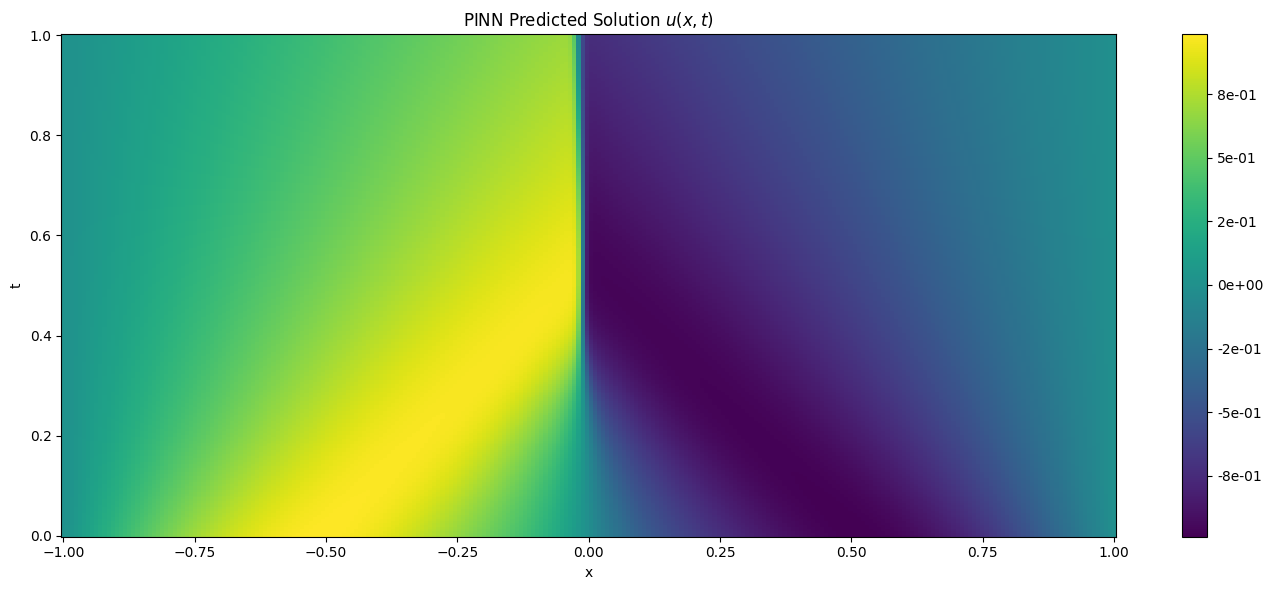

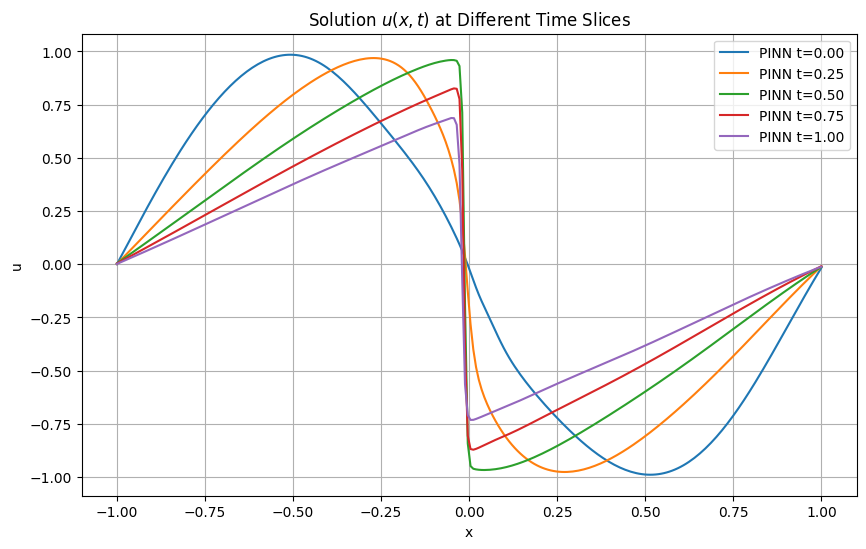

In [8]:
fig, axes = plt.subplots(1, 2 if has_true_solution else 1, figsize=(14, 6))
if not has_true_solution:
    ax1 = axes
elif isinstance(axes, np.ndarray):
    ax1, ax2 = axes
else:
    ax1, ax2 = axes, None

# --- A. PINN Prediction Heatmap ---
h1 = ax1.pcolormesh(X_np, T_np, U_pred_grid, cmap='viridis', shading='auto')
fig.colorbar(h1, ax=ax1, format='%.0e')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_title('PINN Predicted Solution $u(x, t)$')
ax1.set_aspect('auto')


# --- B. True Solution Heatmap (if available) ---
if has_true_solution:
    h2 = ax2.pcolormesh(X_np, T_np, U_true_interpolated, cmap='viridis', shading='auto')
    fig.colorbar(h2, ax=ax2, format='%.0e')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_title('True Solution $u(x, t)$')
    ax2.set_aspect('auto')

plt.tight_layout()
plt.show()


# --- C. Time Slices (Snapshot Plots) ---
plt.figure(figsize=(10, 6))
time_slices = [0.0, 0.25, 0.5, 0.75, 1.0] # Times to plot snapshots

# Find the indices corresponding to these time slices
t_indices = [np.argmin(np.abs(t_test.cpu().numpy() - ts)) for ts in time_slices]

for i, t_idx in enumerate(t_indices):
    plt.plot(x_test.cpu().numpy(), U_pred_grid[t_idx, :], label=f'PINN t={time_slices[i]:.2f}')
    if has_true_solution:
        # For true solution, also find nearest time index if on different grid,
        # or just plot the interpolated U_true_interpolated at this t_idx
        plt.plot(x_test.cpu().numpy(), U_true_interpolated[t_idx, :], 'k--', alpha=0.6, label=f'True t={time_slices[i]:.2f}' if i == 0 else "")


plt.xlabel('x')
plt.ylabel('u')
plt.title('Solution $u(x, t)$ at Different Time Slices')
plt.legend()
plt.grid(True)
plt.show()

-----

### 5\. Quantitative Validation (Error Calculation)

/tmp/ipython-input-1613079337.py:33: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 1400x600 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(h_res, format='%.0e')


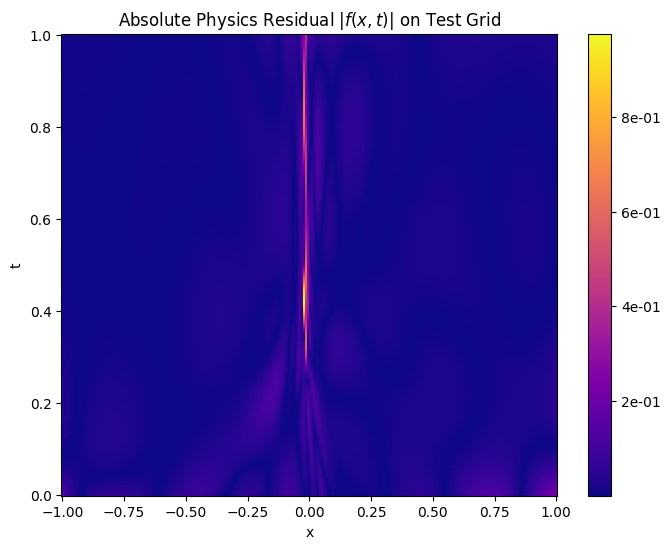

Maximum absolute physics residual on test grid: 9.753799e-01
Mean absolute physics residual on test grid: 1.900247e-02


In [9]:
# --- D. Quantitative Error Calculation ---
if has_true_solution:
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((U_pred_grid - U_true_interpolated)**2)
    print(f"\nMean Squared Error (PINN vs. True): {mse:.6e}")

    # Calculate L2 Relative Error
    l2_relative_error = np.linalg.norm(U_pred_grid - U_true_interpolated) / np.linalg.norm(U_true_interpolated)
    print(f"L2 Relative Error (PINN vs. True): {l2_relative_error:.6e}")

    # --- E. Error Heatmap ---
    plt.figure(figsize=(8, 6))
    error_grid = np.abs(U_pred_grid - U_true_interpolated)
    h_err = plt.pcolormesh(X_np, T_np, error_grid, cmap='magma', shading='auto')
    fig.colorbar(h_err, format='%.0e')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Absolute Error $|u_{pred}(x, t) - u_{true}(x, t)|$')
    plt.show()

# --- F. Physics Residual Check (A Priori Validation) ---
# Calculate the residual on the prediction grid
x_flat_phys_check = X_grid.float().reshape(-1, 1).requires_grad_(True)
t_flat_phys_check = T_grid.float().reshape(-1, 1).requires_grad_(True)

# Make sure the model is in eval mode before passing to physics_residual if it uses batchnorm/dropout
pinn_model.eval()
f_check = physics_residual(pinn_model, x_flat_phys_check, t_flat_phys_check, nu)
F_check_grid = f_check.detach().cpu().numpy().reshape(N_test, N_test)

plt.figure(figsize=(8, 6))
h_res = plt.pcolormesh(X_np, T_np, np.abs(F_check_grid), cmap='plasma', shading='auto')
fig.colorbar(h_res, format='%.0e')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Physics Residual $|f(x, t)|$ on Test Grid')
plt.show()

print(f"Maximum absolute physics residual on test grid: {np.max(np.abs(F_check_grid)):.6e}")
print(f"Mean absolute physics residual on test grid: {np.mean(np.abs(F_check_grid)):.6e}")

-----

By running this code after your training loop, you will generate:

1.  Heatmaps of your PINN's predicted solution (and the true solution, if available).
2.  Snapshots of the solution at different times.
3.  Quantitative error metrics (MSE, L2 relative error) if a true solution is provided.
4.  A heatmap of the physics residual on the entire domain, indicating where the PDE is satisfied well or poorly.

This comprehensive set of visualizations and validation steps will give you a clear picture of your PIML model's performance for Burger's Equation. Good luck with the analysis of your results\!